In [334]:
import os
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
import random

from numpy import array
from numpy import hstack

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

from sklearn.preprocessing import StandardScaler

In [335]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

%config InlineBackend.figure_formatrmat = 'retina'

In [336]:
from stesml.data_tools import get_train_and_test_index
from stesml.data_tools import load_data
from stesml.data_tools import series_to_supervised
from stesml.data_tools import get_train_data
from stesml.data_tools import get_test_data


from stesml.plot_tools import get_plot_data
from stesml.plot_tools import plot_test_results
from stesml.plot_tools import plot_average_error
from stesml.plot_tools import plot_progress_results

from stesml.postprocessing_tools import get_Cp
from stesml.postprocessing_tools import get_Ac
from stesml.postprocessing_tools import get_m
from stesml.postprocessing_tools import get_As
from stesml.postprocessing_tools import get_h

In [15]:
from sklearn.model_selection import RepeatedKFold

In [16]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [17]:
import datetime

In [18]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [19]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=0,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [20]:
data_dir = "../data/Sulfur_Models/"

scenario_index = pd.DataFrame({"filepath": glob.glob(os.path.join(data_dir, "ML_*_*.csv"))})

In [21]:
train_index, test_index = get_train_and_test_index(scenario_index, random_state=5)

In [634]:
def get_short_data(X, y, t):
    X = pd.DataFrame(X)
    indexes = X[0] > t
    X = X[indexes]
    y = y[indexes]
    return X, y

In [635]:
def get_train_and_test_data(scenario_index, train_index, test_index, target='Tavg', scale=False, t=0):
    X_train, y_train = get_train_data(scenario_index, train_index, test_index, target=target)
    X_test, y_test = get_test_data(scenario_index, test_index, target=target)
    if t > 0:
        X_train, y_train = get_short_data(X_train, y_train, t)
        X_test, y_test = get_short_data(X_test, y_test, t)
    if scale:
        scaler_x = StandardScaler().fit(X_train)
        X_train = scaler_x.transform(X_train)
        X_test = scaler_x.transform(X_test)  

        scaler_y = StandardScaler().fit(y_train.reshape(-1,1))
        y_train = scaler_y.transform(y_train.reshape(-1,1)).reshape(1,-1)[0]
        y_test = scaler_y.transform(y_test.reshape(-1,1)).reshape(1,-1)[0]
    return X_train, y_train, X_test, y_test

In [636]:
def build_model():
    model = Sequential()
    model.add(Dense(50, activation='relu', input_shape=(n_features,)))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.build()
    #model.summary()
    return model

In [662]:
target = 'Tavg'
scale = True

In [663]:
n_shuffles = 20

r2_tot = 0
rmse_tot = 0

for i in range(n_shuffles):
    train_index, test_index = get_train_and_test_index(scenario_index)
    X_train, y_train, X_test, y_test = get_train_and_test_data(scenario_index, train_index, test_index, target, scale, t=0)
    model = build_model()
    model.fit(x=X_train, 
          y=y_train,
          batch_size=30,
          epochs=1,
          validation_data=(X_test, y_test), 
          callbacks=[tensorboard_callback])
    y_hat = model.predict(X_test)
    if scale:
        y_hat = scaler_y.inverse_transform(y_hat.reshape(-1,1)).reshape(1,-1)[0]
        y_test = scaler_y.inverse_transform(y_test.reshape(-1,1)).reshape(1,-1)[0]
    r2 = r2_score(y_test, y_hat)
    rmse = mean_squared_error(y_test, y_hat, squared=False)
    
    print('RMSE: {rmse:.4f}, r2: {r2:.4f}'.format(rmse=rmse,r2=r2))
    
    r2_tot += r2
    rmse_tot += rmse
    
    r2_avg = r2_tot/(i+1)
    rmse_avg = rmse_tot/(i+1)
    
    print('RMSE AVG: {rmse_avg:.4f}, r2 AVG: {r2_avg:.4f}'.format(rmse_avg=rmse_avg,r2_avg=r2_avg))

Train on 1447459 samples, validate on 361790 samples
Epoch 1/20
1447459/1447459 [==============================] - 109s 75us/sample - loss: 3.5695e-04 - val_loss: 0.0073
Epoch 2/20
1447459/1447459 [==============================] - 112s 77us/sample - loss: 4.6886e-05 - val_loss: 0.0104
Epoch 3/20
 121740/1447459 [=>............................] - ETA: 1:19 - loss: 3.9170e-05

KeyboardInterrupt: 

In [649]:
y_hat = model.predict(X_test)

In [650]:
if scale:
    y_hat = scaler_y.inverse_transform(y_hat.reshape(-1,1)).reshape(1,-1)[0]
    y_test = scaler_y.inverse_transform(y_test.reshape(-1,1)).reshape(1,-1)[0]

In [651]:
print(r2_score(y_test, y_hat))

0.793092022800999


In [652]:
print(mean_squared_error(y_test, y_hat, squared=False))

23.689661958940476


In [653]:
import matplotlib.pyplot as plt

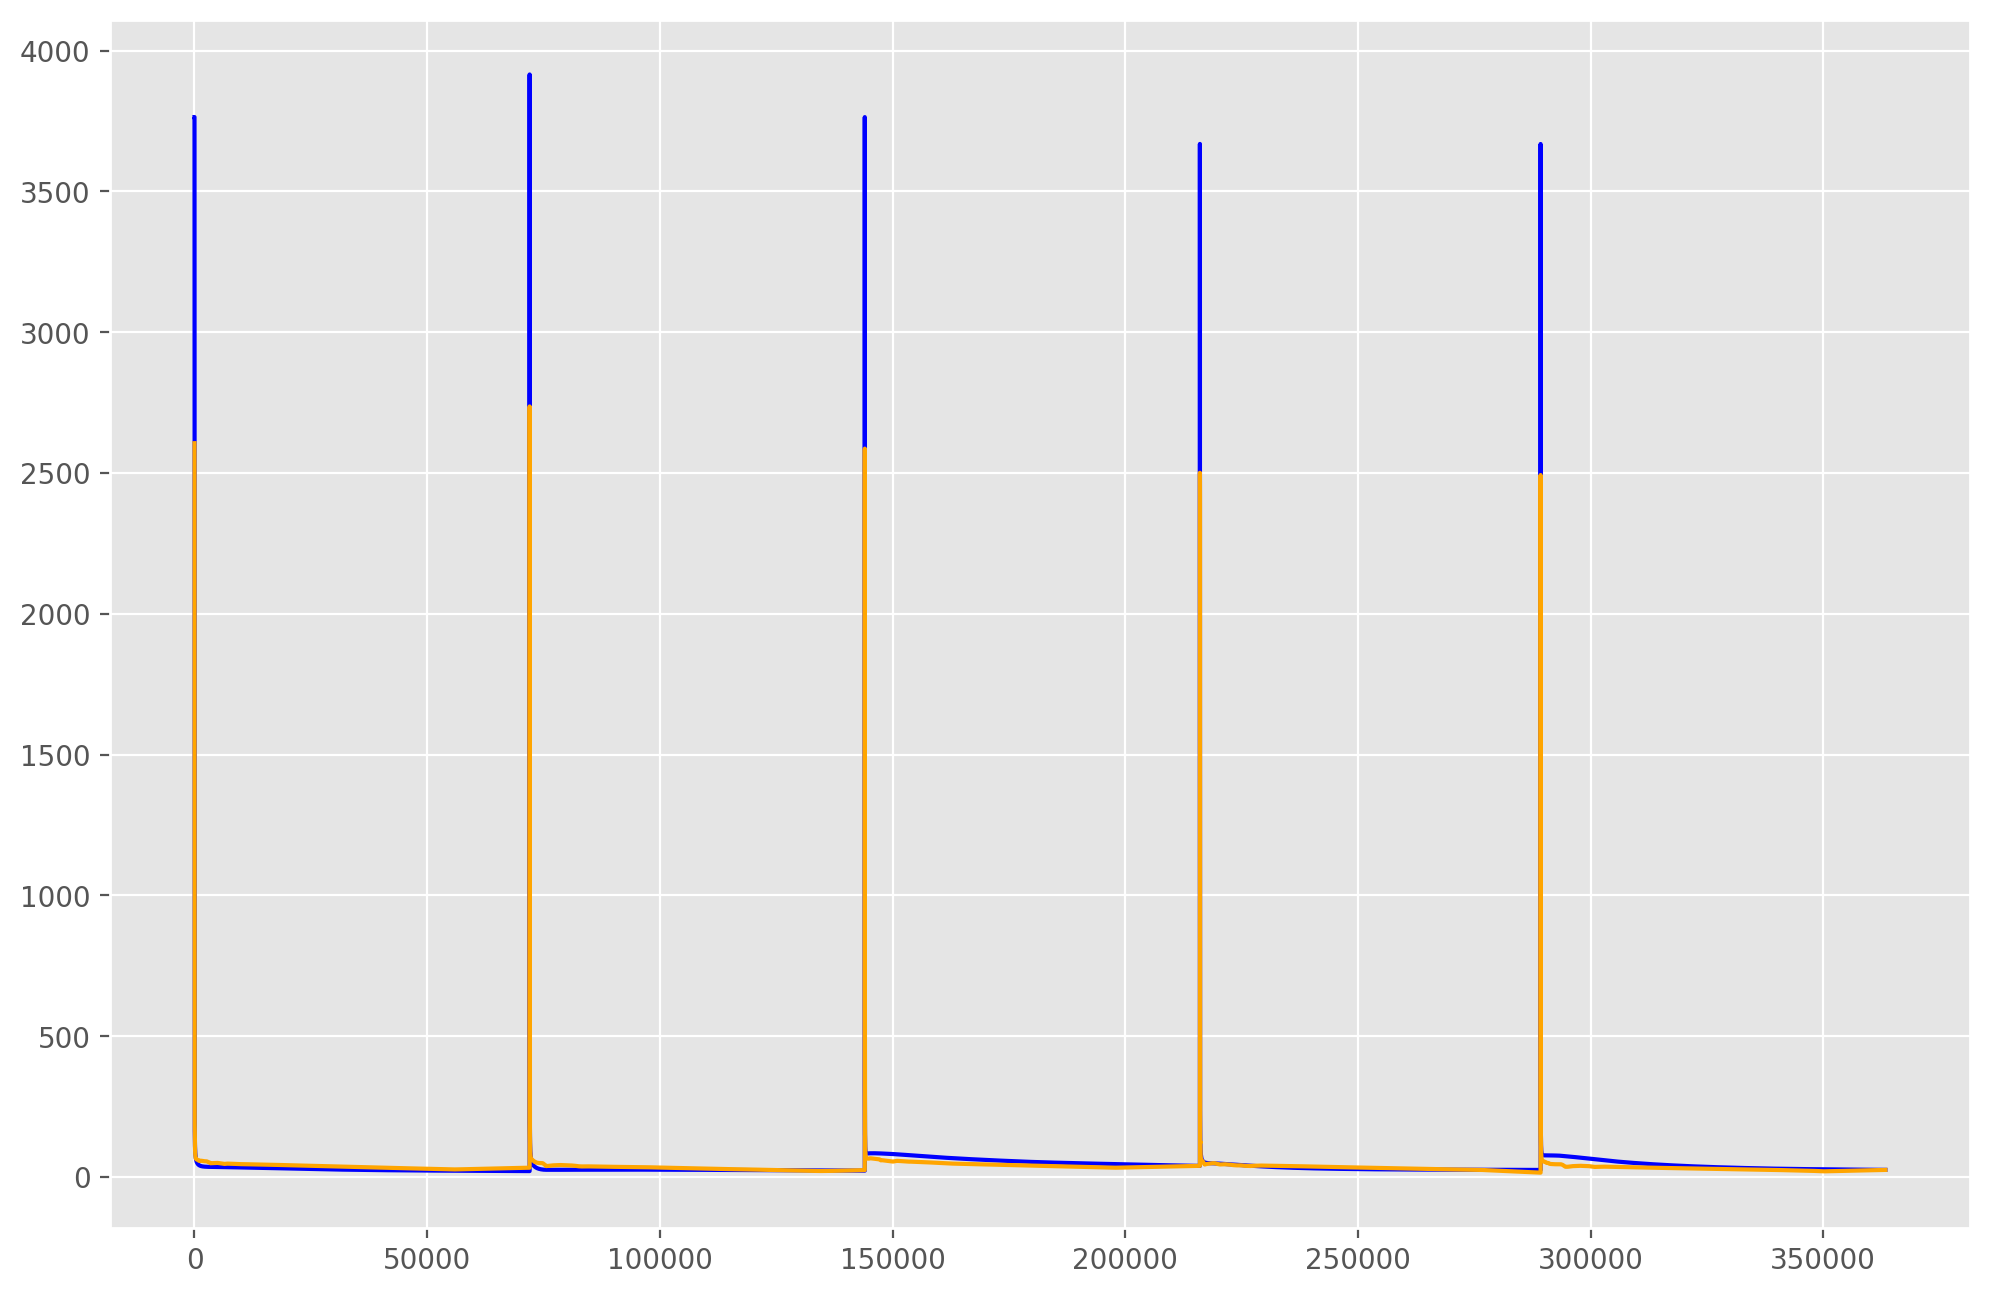

In [654]:
fig, ax = plt.subplots(figsize=(12,8), dpi= 200, facecolor='w', edgecolor='k')
ax.plot(y_test, color='blue')
ax.plot(y_hat, color='orange')
plt.show()

In [655]:
test_df = load_data(scenario_index, test_index)

In [656]:
test_df[target+"_hat"] = y_hat

In [657]:
test_df_plot = get_plot_data(y_hat, test_df, test_index, is_recurrent, target=target)

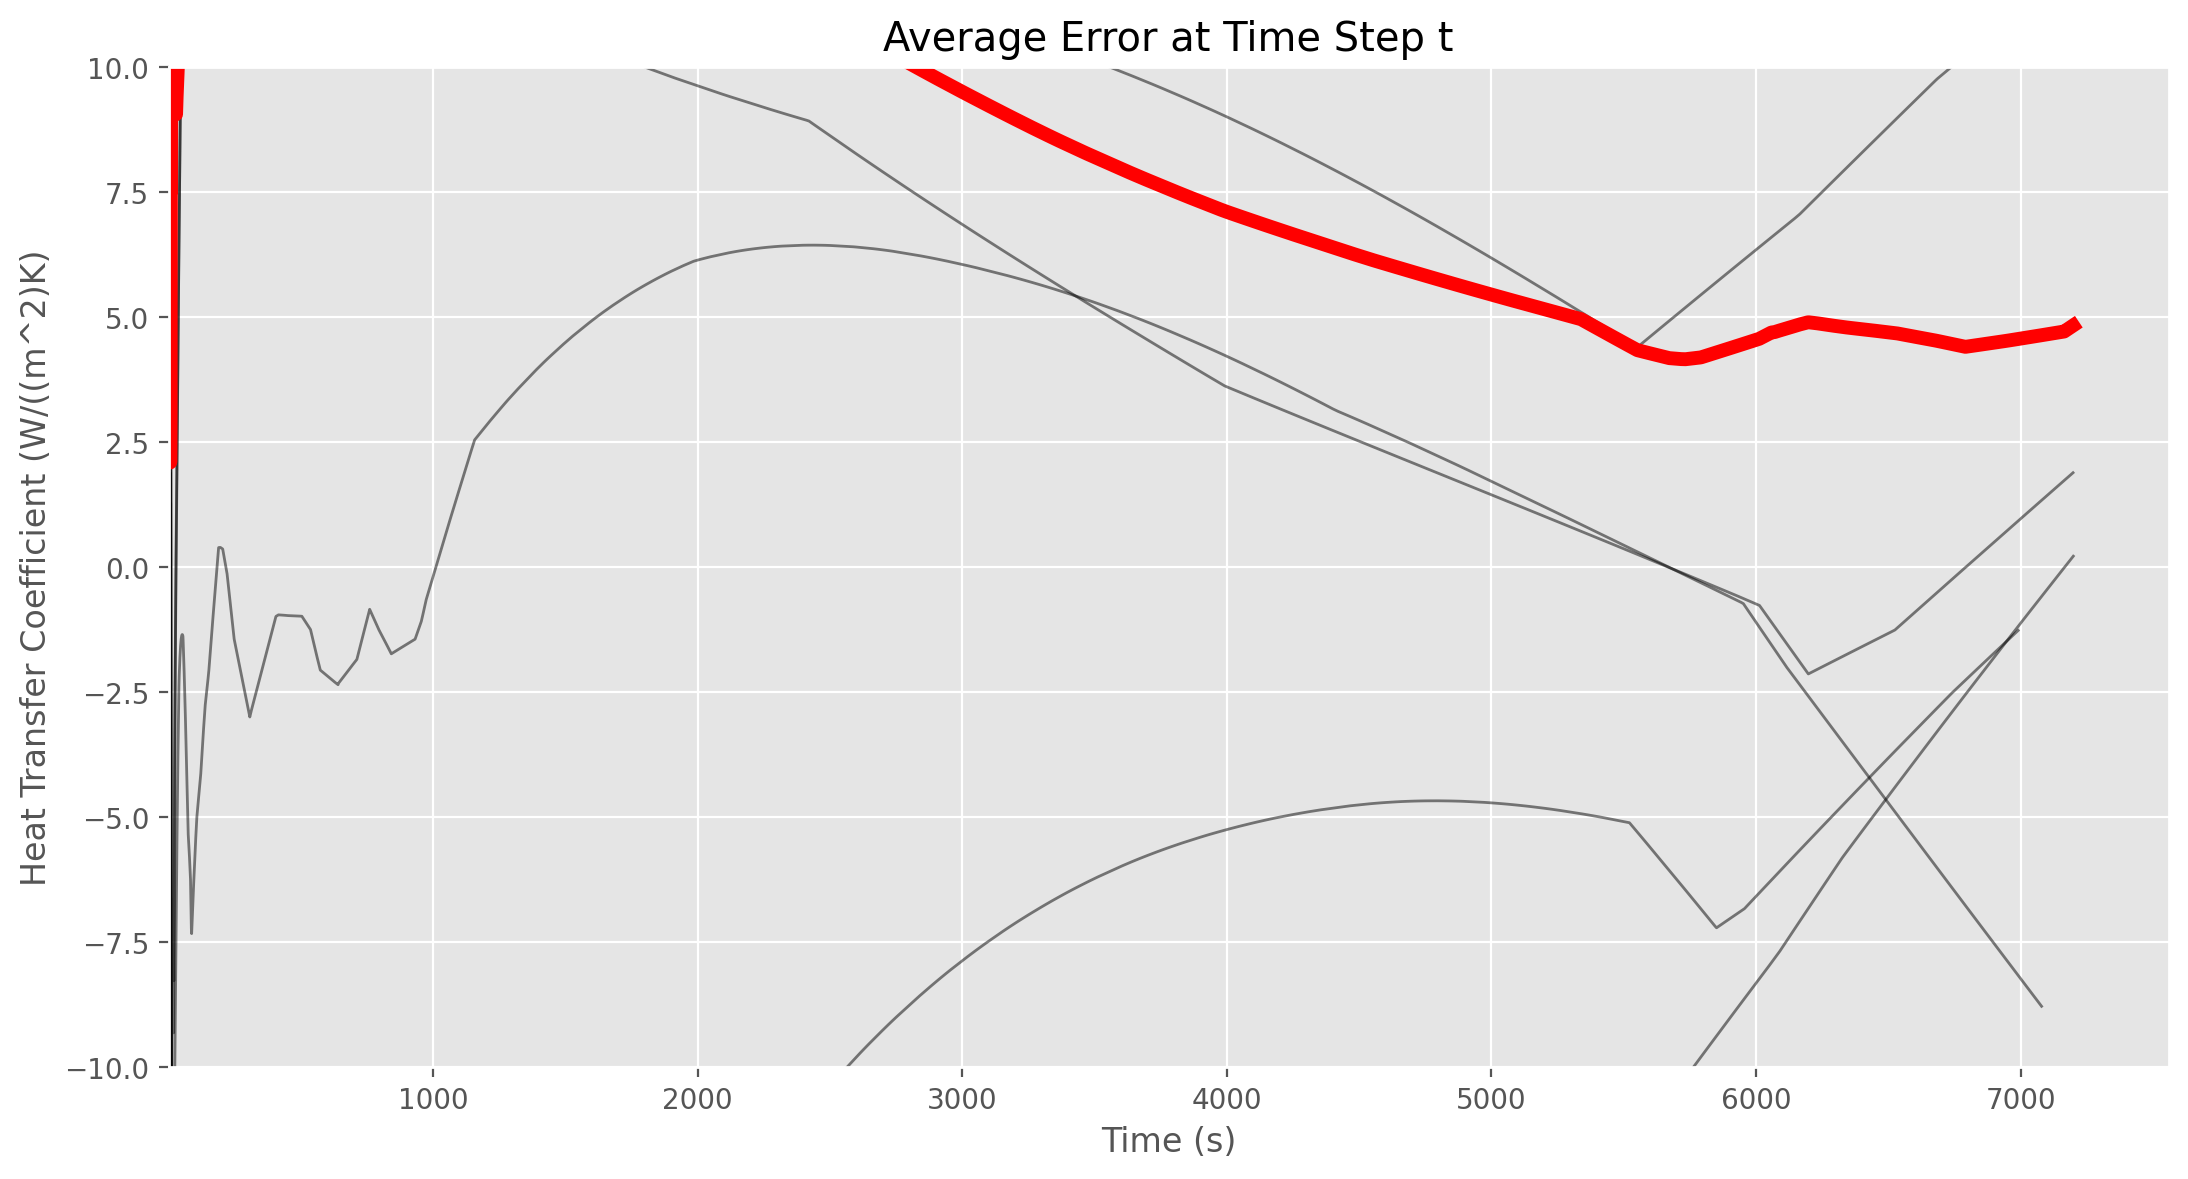

In [658]:
plot_average_error(test_df_plot, target=target)

<AxesSubplot:>

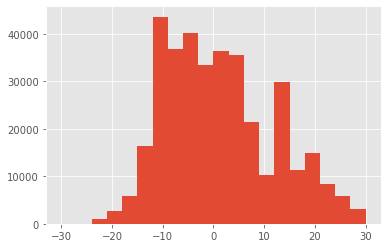

In [659]:
(test_df_plot[target] - test_df_plot[target+'_hat']).hist(bins=20, range=(-30, 30))

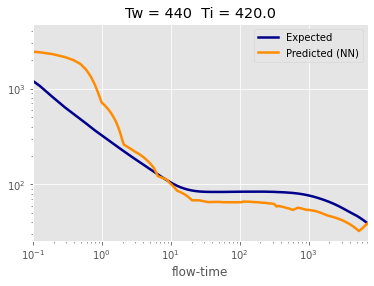

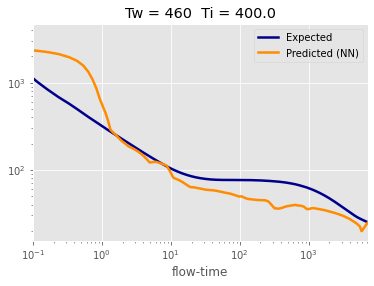

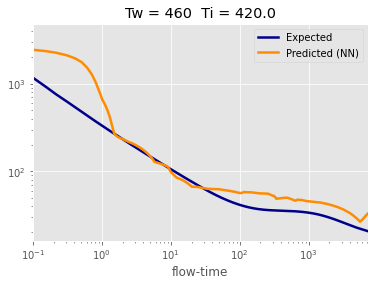

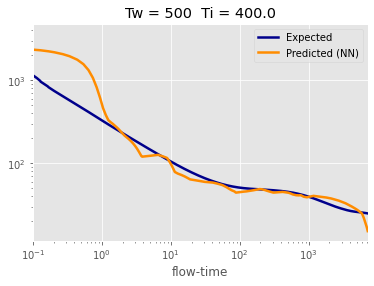

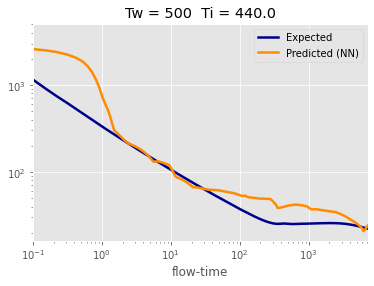

In [660]:
plot_test_results(test_df_plot, model_type='NN', target=target)